In [125]:
import numpy as np
import matplotlib.pyplot as plt

In [75]:
def forward_pass(x_nor, x0, u):
    x = np.zeros(T+1)  
    du = np.zeros(T)

    A = 1
    B = 1
    
    x[0] = x0
    for t in range(T):
        du[t] = k[t] + K[t] * (x[t] - x_nor[t])
        u[t] += du[t]

        # linear rollout
        x[t+1] = x_nor[t+1] + A * (x[t] - x_nor[t]) + B * du[t]
        
    return x, u

In [76]:
def cost(x, u, x_target, Q, R):
    J = 0
    for t in range(T):
        J += 0.5 * Q * (x[t] - x_target)**2 + 0.5 * R * u[t]**2
    J += 0.5 * (x[T] - x_target)**2
    return J

In [99]:
def backward_pass(x, u, x_target, Q, R):
    Vx = np.zeros(T+1)
    Vxx = np.zeros(T+1)
    k = np.zeros(T)
    K = np.zeros(T)
    
    # Final cost-to-go
    Vx[T] = Q * ( x[T] - x_target )
    Vxx[T] = Q
    
    for t in reversed(range(T)):
        A = 1
        B = 1
        
        Qx = Q * ( x[t] - x_target )  + A * Vx[t+1]
        Qu = R * u[t]
        
        Qxx = Q + A * Vxx[t+1] * A
        Qux = B * Vxx[t+1] * A
        Quu = R + B * Vxx[t+1] * B
        
        k[t] = -Qu / Quu
        K[t] = -Qux / Quu
        
        Vx[t] = Qx - Qux / Quu * Qu
        Vxx[t] = Qxx + Qux / Quu * Qux
    
    return k, K

In [123]:
# Initialization

T = 10  # Number of time steps
x0 = 12 # Initial position
x_target = 10  # Target position

Q = 4  # State deviation weight
R = 1  # Control effort weight

x = np.zeros(T+1)
u = np.zeros(T)
J_list = np.zeros(0)

J = cost(x, u, x_target, Q, R)
J_list = np.append(J_list, J)
J_prev = 0

tol = 1e-5
iter = 0
maxiter = 3e4

# Main iLQR loop
while (abs(J - J_prev) >  tol) and ( iter <  maxiter ) :  # Number of iterations    

    J_prev = J
    
    k, K = backward_pass(x, u, x_target, Q, R)
    
    x, u  = forward_pass(x, x0, u)

    J = cost(x, u, x_target, Q, R)
    J_list = np.append(J_list, J)

    iter += 1

# Print final trajectories
print("Final state trajectory:", x)
print("Final control inputs:", u)
print("Cost evoluation:", J_list)


Final state trajectory: [12.         11.31434733 10.66878117 10.25234707 10.01900971  9.89644662
  9.83432524  9.8037122   9.78917794  9.78277255  9.78048272]
Final control inputs: [-0.68565267 -0.64556617 -0.4164341  -0.23333736 -0.12256309 -0.06212138
 -0.03061304 -0.01453427 -0.00640538 -0.00228983]
Cost evoluation: [2050.         1929.82885502 1929.65774953 ...   13.40583159   13.40581334
   13.40580433]


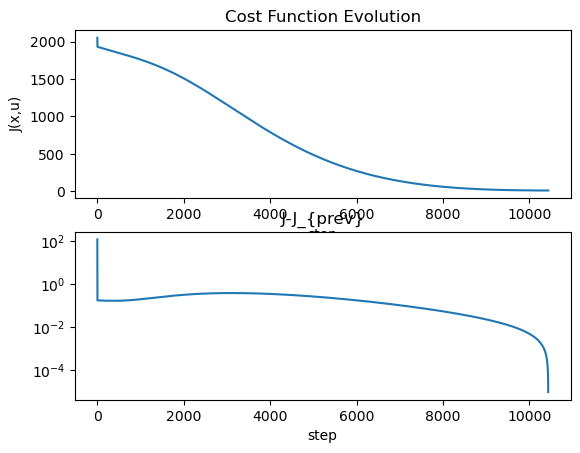

In [124]:

fig, ax = plt.subplots(2,1)
ax[0].plot(J_list)
ax[0].set_ylabel('J(x,u)')
ax[0].set_xlabel('step')
ax[0].set_title('Cost Function Evolution')

ax[1].plot(abs(J_list[1:]-J_list[:-1]))
ax[1].set_xlabel('step')
ax[1].set_title(' J-J_{prev} ')
ax[1].set_yscale('log')

plt.show()

